# Transformer Network Application: Named-Entity Recognition

In this notebook you'll explore one application of the transformer architecture that you built in the previous assignment.

**After this assignment you'll be able to**:

* Use tokenizers and pre-trained models from the HuggingFace Library.
* Fine-tune a pre-trained transformer model for Named-Entity Recognition

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt 
import json
import random
import logging
import re
import tqdm
tf.get_logger().setLevel('ERROR')

<a name='1'></a>
## 1 - Named-Entity Recogniton to Process Resumes

When faced with a large amount of unstructured text data, named-entity recognition (NER) can help you detect and classify important information in your dataset. For instance, in the running example "Jane vists Africa in September", NER would help you detect "Jane", "Africa", and "September" as named-entities and classify them as person, location, and time. 

* You will use a variation of the Transformer model you built in the last assignment to process a large dataset of resumes.
* You will find and classify relavent information such as the companies the applicant worked at, skills, type of degree, etc. 

<a name='1-1'></a>
### 1.1 - Dataset Cleaning

In this assignment you will optimize a Transformer model on a dataset of resumes. Take a look at how the data you will be working with are structured.

In [2]:
df_data = pd.read_json("C:/Users/mattg/Downloads/Transformers_project/data/ner.json", lines=True)
df_data = df_data.drop(['extras'], axis=1)
df_data['content'] = df_data['content'].str.replace("\n", " ")

In [3]:
df_data.head()

,content,annotation
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [4]:
df_data.iloc[0]['annotation']

[{'label': ['Skills'],
  'points': [{'start': 1295,
    'end': 1621,
    'text': '\n• Programming language: C, C++, Java\n• Oracle PeopleSoft\n• Internet Of Things\n• Machine Learning\n• Database Management System\n• Computer Networks\n• Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n• Honest and Hard-Working\n• Tolerant and Flexible to Different Situations\n• Polite and Calm\n• Team-Player'}]},
 {'label': ['Skills'],
  'points': [{'start': 993,
    'end': 1153,
    'text': 'C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year),\nDatabase Management System (Less than 1 year), Java (Less than 1 year)'}]},
 {'label': ['College Name'],
  'points': [{'start': 939, 'end': 956, 'text': 'Kendriya Vidyalaya'}]},
 {'label': ['College Name'],
  'points': [{'start': 883, 'end': 904, 'text': 'Woodbine modern school'}]},
 {'label': ['Graduation Year'],
  'points': [{'start': 856, 'end': 860, 'text': '2017\n'}]},
 {'label': ['College 

In [5]:
def mergeIntervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1])
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)
    return merged

In [6]:
def get_entities(df):
    
    entities = []
    
    for i in range(len(df)):
        entity = []
    
        for annot in df['annotation'][i]:
            if 'label' in annot and annot['label']:
                ent = annot['label'][0]
                start = annot['points'][0]['start']
                end = annot['points'][0]['end'] + 1
                entity.append((start, end, ent))
    
        entity = mergeIntervals(entity)
        entities.append(entity)
    
    return entities

In [7]:
df_data['entities'] = get_entities(df_data)
df_data.head()

,content,annotation,entities
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...","[(0, 12, Name), (13, 46, Designation), (49, 58..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...","[(0, 14, Name), (62, 68, Location), (104, 148,..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...","[(0, 21, Name), (22, 31, Location), (65, 117, ..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...","[(0, 12, Name), (13, 51, Designation), (54, 60..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...","[(0, 13, Name), (14, 22, Designation), (24, 41..."


In [8]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    labels = [label for label in labels if label and label.strip().lower() not in ["", "empty", "unknown"]]

                    if not labels:
                        continue
                    
                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data  

In [9]:
data = trim_entity_spans(convert_dataturks_to_spacy("C:/Users/mattg/Downloads/Transformers_project/data/ner.json"))


In [10]:
from tqdm.notebook import tqdm

def clean_dataset(data):
    all_rows = []
    sum1 = 0

    for i in tqdm(range(len(data))):
        start = 0
        sentence = data[i][0]
        entity_dict = data[i][1]
        emptyList = ["Empty"] * len(sentence.split())
        numberOfWords = 0
        lenOfString = len(sentence)
        lastIndexOfSpace = sentence.rfind(' ')

        for i_char in range(lenOfString):
            if sentence[i_char] == " " and sentence[i_char + 1] != " ":
                for k, v in entity_dict.items():
                    for entList in reversed(v):
                        if start >= int(entList[0]) and i_char <= int(entList[1]):
                            emptyList[numberOfWords] = entList[2]
                            break
                start = i_char + 1  
                numberOfWords += 1

            if i_char == lastIndexOfSpace:
                for entList in reversed(entity_dict.get('entities', [])):
                    if lastIndexOfSpace >= int(entList[0]) and lenOfString <= int(entList[1]):
                        emptyList[numberOfWords] = entList[2]
                        numberOfWords += 1

        all_rows.append(emptyList)
        sum1 += numberOfWords

    # create final DataFrame
    cleanedDF = pd.DataFrame({'setences_cleaned': all_rows})
    return cleanedDF


In [11]:
cleanedDF = clean_dataset(data)

  0%|          | 0/220 [00:00<?, ?it/s]

Take a look at your cleaned dataset and the categories the named-entities are matched to, or 'tags'.

In [12]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


<a name='1-2'></a>
### 1.2 - Padding and Generating Tags

Now, it is time to generate a list of unique tags you will match the named-entities to. Seqeval (used below) expects BIO or IOB format like:
["B-NAME", "I-NAME", "O", "B-EMAIL"], but our labels are plain tags like "Name", "Email Address", "Empty" which are not in BIO format. So, here I update tag2id and id2tag. 

In [13]:
unique_tags = set()
for row in cleanedDF["setences_cleaned"]:
    for tag in row:
        if tag != "Empty":
            unique_tags.add("B-" + tag)
            unique_tags.add("I-" + tag)
        else:
            unique_tags.add("O")

tag2id = {tag: idx for idx, tag in enumerate(sorted(unique_tags))}
id2tag = {v: k for k, v in tag2id.items()}

In [14]:
unique_tags

{'B-College Name',
 'B-Companies worked at',
 'B-Degree',
 'B-Designation',
 'B-Email Address',
 'B-Graduation Year',
 'B-Location',
 'B-Name',
 'B-Skills',
 'B-Years of Experience',
 'I-College Name',
 'I-Companies worked at',
 'I-Degree',
 'I-Designation',
 'I-Email Address',
 'I-Graduation Year',
 'I-Location',
 'I-Name',
 'I-Skills',
 'I-Years of Experience',
 'O'}

Next, you will create an array of tags from your cleaned dataset. Oftentimes, your input sequence can exceeds the maximum length of a sequence your network can process, so it needs to be cut off to that desired maximum length. And when the input sequence is shorter than the desired length, you need to append zeroes onto its end using this [Keras padding API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
MAX_LEN = 512

def convert_to_bio_tags(cleaned_data):
    bio_data = []
    for row in cleaned_data:
        bio_row = []
        prev_tag = None
        for tag in row:
            if tag == "Empty":
                bio_row.append("O")
                prev_tag = None
            elif tag != prev_tag:
                bio_row.append("B-" + tag)
                prev_tag = tag
            else:
                bio_row.append("I-" + tag)
        bio_data.append(bio_row)
    return bio_data


bio_labels = convert_to_bio_tags(cleanedDF["setences_cleaned"])

tags = pad_sequences([[tag2id.get(tag, tag2id["O"]) for tag in row] for row in bio_labels],
                     maxlen=MAX_LEN, value=tag2id["O"], padding="post", truncating="post")


In [17]:
tags

array([[ 7, 17,  3, ..., 20, 20, 20],
       [ 7, 17, 20, ..., 20, 20, 20],
       [ 7, 17, 17, ..., 20,  8, 20],
       ...,
       [ 7, 17,  3, ..., 20, 20, 20],
       [ 7, 17,  3, ..., 20, 20, 20],
       [ 7, 17,  3, ..., 20, 20, 20]])

<a name='1-3'></a>
### 1.3 - Tokenize and Align Labels with 🤗 Library

Before feeding the texts to a Transformer model, you will need to tokenize your input using a [🤗 Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html). It is crucial that the tokenizer you use must match the Transformer model type you are using! In this exercise, you will use the 🤗 [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html), which standardizes the length of your sequence to 512 and pads with zeros. Notice this matches the maximum length you used when creating tags. 

In [18]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [19]:
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
tokenizer = DistilBertTokenizerFast.from_pretrained('C:/Users/mattg/Downloads/Transformers_project/tokenizers/ner')

Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that you align the lists of tags and the list of labels generated by the selected tokenizer with a `tokenize_and_align_labels()` function.

<a name='ex-1'></a>
### Exercise 1 - tokenize_and_align_labels

Implement `tokenize_and_align_labels()`. The function should perform the following:
* The tokenizer cuts sequences that exceed the maximum size allowed by your model with the parameter `truncation=True`
* Aligns the list of tags and labels with the tokenizer `word_ids` method returns a list that maps the subtokens to the original word in the sentence and special tokens to `None`. 
* Set the labels of all the special tokens (`None`) to -100 to prevent them from affecting the loss function. 
* Label of the first subtoken of a word and set the label for the following subtokens to -100. 

In [20]:
label_all_tokens = True
def tokenize_and_align_labels(tokenizer, examples, tags):
    tokenized_inputs = tokenizer(examples, truncation=True, is_split_into_words=False, padding='max_length', max_length=512)
    labels = []
    for i, label in enumerate(tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Now that you have tokenized inputs, you can create train and test datasets!

In [21]:
test = tokenize_and_align_labels(tokenizer, df_data['content'].values.tolist(), tags)
train_dataset = tf.data.Dataset.from_tensor_slices({
    "input_ids": test["input_ids"],
    "attention_mask": test["attention_mask"],
    "labels": test["labels"]
})

# train_dataset = tf.data.Dataset.from_tensor_slices((test['input_ids'], test['labels']))

<a name='1-4'></a>
### 1.4 - Optimization

Fantastic! Now you can finally feed your data into into a pretrained 🤗 model. You will optimize a DistilBERT model, which matches the tokenizer you used to preprocess your data. Try playing around with the different hyperparamters to improve your results!

In [22]:
from transformers import TFDistilBertForTokenClassification

# model = TFDistilBertForTokenClassification.from_pretrained('C:/Users/mattg/Downloads/Transformers_project/models/ner', num_labels=len(unique_tags))
model = TFDistilBertForTokenClassification.from_pretrained(
    'distilbert-base-uncased',  # start from base model
    num_labels=len(tag2id)
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able t

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Flatten labels, filter out -100
flat_labels = np.array(test['labels']).flatten()
valid_labels = flat_labels[flat_labels != -100]

# Get unique class indices
unique_labels = np.unique(valid_labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=valid_labels)

# Now map actual label value (not index!) to weight
class_weight_dict = {int(label): weight for label, weight in zip(unique_labels, class_weights)}


In [24]:
import tensorflow as tf

def weighted_sparse_categorical_loss(class_weights):
    weights_array = np.zeros(max(class_weight_dict.keys()) + 1)
    for label, weight in class_weight_dict.items():
        weights_array[label] = weight
    
    weights = tf.constant(weights_array, dtype=tf.float32)


    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)

        # Mask out -100 labels (used to ignore padding tokens)
        mask = tf.not_equal(y_true, -100)

        # Replace -100 with 0 temporarily (safe since we’ll mask the loss anyway)
        y_true_clean = tf.where(mask, y_true, tf.zeros_like(y_true))

        # Compute loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_clean, y_pred, from_logits=True)

        # Apply class weights
        weight_mask = tf.gather(weights, y_true_clean)
        weighted_loss = loss * tf.cast(weight_mask, tf.float32)

        # Apply the final mask so -100s don’t count toward loss
        masked_loss = tf.where(mask, weighted_loss, tf.zeros_like(weighted_loss))
        return tf.reduce_mean(masked_loss)

    return loss_fn


In [ ]:
from transformers import create_optimizer

num_epochs = 100
num_train_steps = len(train_dataset) * num_epochs 
num_warmup_steps = int(0.1 * num_train_steps)
optimizer, schedule = create_optimizer(init_lr=1e-5, num_warmup_steps=num_warmup_steps, num_train_steps=num_train_steps)

# Apply gradient clipping
optimizer.clipnorm = 1.0
loss_fn = weighted_sparse_categorical_loss(class_weight_dict)
model.compile(optimizer=optimizer, loss=loss_fn)

model.fit(train_dataset.batch(4).prefetch(tf.data.AUTOTUNE), epochs=num_epochs)

Epoch 1/100
55/55 [==============================] - 48s 741ms/step - loss: 2.5674
Epoch 2/100
55/55 [==============================] - 41s 748ms/step - loss: 2.5629
Epoch 3/100
55/55 [==============================] - 40s 733ms/step - loss: 2.5524
Epoch 4/100
55/55 [==============================] - 40s 730ms/step - loss: 2.5387
Epoch 5/100
55/55 [==============================] - 40s 733ms/step - loss: 2.5227
Epoch 6/100
55/55 [==============================] - 40s 729ms/step - loss: 2.4953
Epoch 7/100
55/55 [==============================] - 40s 728ms/step - loss: 2.4646
Epoch 8/100
55/55 [==============================] - 41s 740ms/step - loss: 2.4112
Epoch 9/100
55/55 [==============================] - 40s 736ms/step - loss: 2.3333
Epoch 10/100
55/55 [==============================] - 40s 728ms/step - loss: 2.2184
Epoch 11/100
55/55 [==============================] - 40s 729ms/step - loss: 2.1229
Epoch 12/100
55/55 [==============================] - 40s 732ms/step - loss: 2.0360
E

In [26]:
model.save_pretrained('C:/Users/mattg/Downloads/Transformers_project/models/ner/bio_model')
tokenizer.save_pretrained('C:/Users/mattg/Downloads/Transformers_project/tokenizers/ner/bio_model')

('C:/Users/mattg/Downloads/Transformers_project/tokenizers/ner/bio_model\\tokenizer_config.json',
 'C:/Users/mattg/Downloads/Transformers_project/tokenizers/ner/bio_model\\special_tokens_map.json',
 'C:/Users/mattg/Downloads/Transformers_project/tokenizers/ner/bio_model\\vocab.txt',
 'C:/Users/mattg/Downloads/Transformers_project/tokenizers/ner/bio_model\\added_tokens.json',
 'C:/Users/mattg/Downloads/Transformers_project/tokenizers/ner/bio_model\\tokenizer.json')

In [27]:
# compute real PAD-token-excluded accuracy
logits_PAD_token_excl = model.predict(train_dataset.batch(4))['logits']
predictions_PAD_token_excl = np.argmax(logits_PAD_token_excl, axis=-1)

true_labels_PAD_token_excl = np.array(test["labels"])
mask_PAD_token_excl = true_labels_PAD_token_excl != -100

correct = (predictions_PAD_token_excl == true_labels_PAD_token_excl) & mask_PAD_token_excl
masked_accuracy = correct.sum() / mask_PAD_token_excl.sum()
print("Masked Accuracy:", masked_accuracy)

55/55 [==============================] - 12s 200ms/step
Masked Accuracy: 0.8086706855817009


In [28]:
text = "Manisha Bharti. 3.5 years of professional IT experience in Banking and Finance domain"
inputs = tokenizer(text, return_tensors="tf", truncation=True, is_split_into_words=False, padding="max_length", max_length=512)
input_ids = inputs["input_ids"]

In [29]:
output = model(inputs).logits
prediction = np.argmax(output, axis=2)
print( prediction)

[[19  7  7 17 17 17  9  9 19 19 19 19 19 13 19 13  0 13  9  0  9  0  8  8
   0  7  7  6 17 17 17  9 17  6  9  9 19 19 19 19 13 19 13 13  0  8  0  8
   8  0  0  7  7  7  7  7  7 17 17 17 17  9  9 19 19 19 19 19 19 13  8  0
  13  0  0  0  0  0  0  0  6  6  6  6  7  7 17 17 17  9  9  9 19 19 19 19
  19 19 13 13 13 13 13  0  0  8  0  0  0  6  7  7  7 17 17 17  9 17  9 19
  19 19 19 19 19 13 19 13  0  7  7 17 17 17  9  9  9 19 19 19 19 19 19 19
   7  7 17 17  9  9  9  9  9 19 19 19 19 19 19 13 13  8  0 13  0  0  0  0
   8  0  0  7  7  7  0  7  7 17 17 17  9  9 19 19 19 19 19 19 19 19 19 19
  13 13  8  0  8  0  0  8  0  0  0  0  0  0  7  7 19  6  7  7  7 17 17 17
   9 19 19 19 19 19 13 13  8  0 13  0  0  0  9  0  0  8  0 19 19  8  0  0
   7  7  7  0  0  0  0  0  0  0  0  0  7  7  7 17 17 17 17  9 19 19 19 19
  19 19 19 19 19 13 13 13 13  0  8  0  8  0  0  0  0  0  0  0  0  6 19  6
  13  6 13 17 13  0  6  6  9  9  9 19 19 19 19 19 19 19 13 13 13 13  0 13
  13 11  0  0  0  0  8 19 19 19 19 19 

In [30]:
model(inputs)

TFTokenClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 512, 21), dtype=float32, numpy=
array([[[ 4.7740272e-01, -1.4785868e-01, -4.3077719e-01, ...,
          2.8222123e-01,  1.5753314e+00, -1.3064322e-02],
        [ 6.3203520e-01, -5.8166826e-01, -3.8016704e-01, ...,
         -5.7798669e-02, -1.2768720e+00, -6.3911676e-01],
        [ 5.0027752e-01, -5.3164232e-01, -3.0515373e-01, ...,
          5.8826953e-03, -8.4029907e-01, -5.3272355e-01],
        ...,
        [ 9.0278500e-01,  1.5722031e-03, -3.6725815e-02, ...,
         -1.0441664e+00, -2.2295105e-01,  3.4596324e-01],
        [ 1.0035973e+00, -3.7001306e-01,  8.4508449e-02, ...,
         -1.1238136e+00,  8.7208271e-02,  9.3310103e-02],
        [ 1.2429093e+00, -4.9051651e-01,  5.4662945e-03, ...,
         -1.1707495e+00,  4.8477572e-01,  1.3475171e-01]]], dtype=float32)>, hidden_states=None, attentions=None)

In [31]:
pred_labels = []

In [32]:
!pip install seqeval

In [33]:
# true_labels = [[id2tag.get(true_index, "Empty") for true_index in test['labels'][i]] for i in range(len(test['labels']))]
true_labels = [
    [id2tag[true_index] if true_index != -100 else "PAD" for true_index in label_seq]
    for label_seq in test["labels"]
]

np.array(true_labels).shape

(220, 512)

In [34]:
output = model.predict(train_dataset.batch(4))

55/55 [==============================] - 11s 199ms/step


In [35]:
predictions = np.argmax(output['logits'].reshape(220, -1, len(unique_tags)), axis=-1)

In [36]:
predictions.shape

(220, 512)

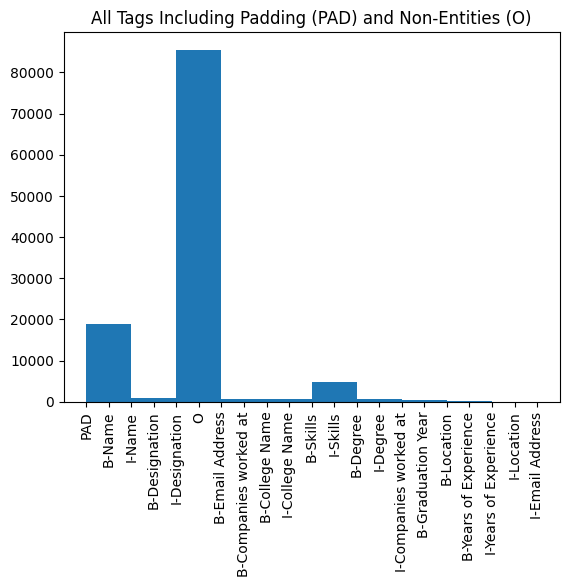

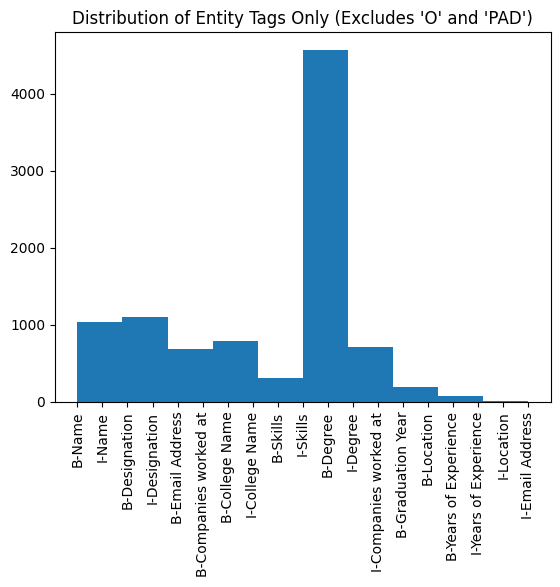

In [37]:
# before filtering
plt.hist(np.array(true_labels).flatten())
plt.xticks(rotation='vertical')
plt.title("All Tags Including Padding (PAD) and Non-Entities (O)")
plt.show()

# after filtering 'O' and 'PAD'
flat_labels = np.array(true_labels).flatten()
filtered = [label for label in flat_labels if label not in {"O", "PAD"}]
plt.hist(filtered)
plt.xticks(rotation='vertical')
plt.title("Distribution of Entity Tags Only (Excludes 'O' and 'PAD')")
plt.show()



In [38]:
from collections import Counter
Counter(np.array(true_labels).flatten())

Counter({'O': 84903,
         'PAD': 18253,
         'I-Skills': 4395,
         'B-Companies worked at': 618,
         'I-Designation': 599,
         'I-College Name': 554,
         'B-Name': 544,
         'B-Designation': 501,
         'I-Name': 491,
         'I-Degree': 425,
         'B-Skills': 309,
         'I-Companies worked at': 290,
         'B-College Name': 238,
         'B-Degree': 173,
         'B-Location': 110,
         'B-Graduation Year': 80,
         'B-Email Address': 72,
         'B-Years of Experience': 39,
         'I-Years of Experience': 36,
         'I-Location': 6,
         'I-Email Address': 4})

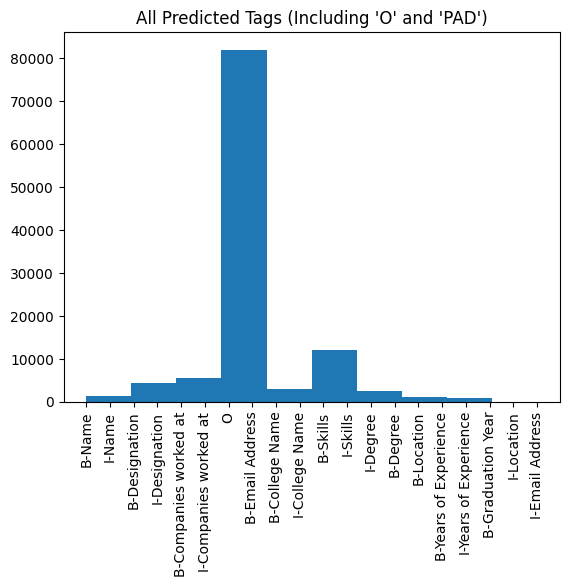

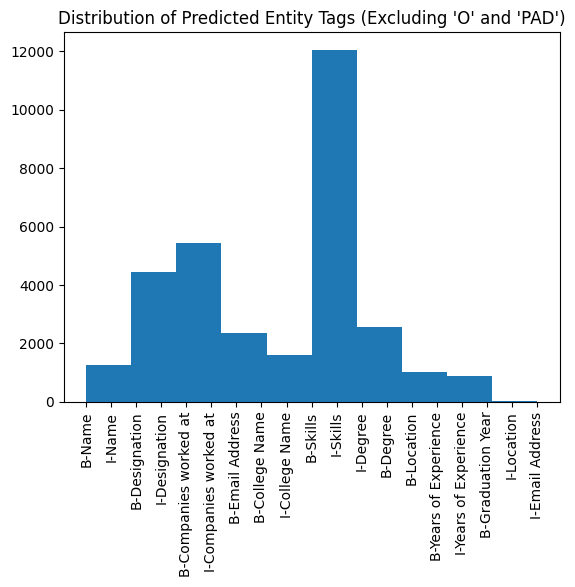

In [39]:
# Decode predicted label indices
pred_labels = [
    [id2tag.get(index, "PAD") for index in seq]
    for seq in predictions
]

# hist of all predicted tags (including O and PAD)
plt.hist(np.array(pred_labels).flatten())
plt.xticks(rotation='vertical')
plt.title("All Predicted Tags (Including 'O' and 'PAD')")
plt.show()

# filter out 'O' and 'PAD' for entity-only distribution
flat_preds = np.array(pred_labels).flatten()
filtered_preds = [label for label in flat_preds if label not in {"O", "PAD"}]
plt.hist(filtered_preds)
plt.xticks(rotation='vertical')
plt.title("Distribution of Predicted Entity Tags (Excluding 'O' and 'PAD')")
plt.show()


It’s expected that Empty dominates, since most tokens in resumes are not entities. However, including "Empty" in evaluation can inflate metrics, since models can just predict Empty and still look accurate. So I will keep Empty during training since it’s important for learning, but exclude it in evaluation below (classification_report) by masking or filtering it out.

In [40]:
from seqeval.metrics import classification_report

def filter_empty_tokens(true_labels, pred_labels, empty_tag="Empty"):
    filtered_true = []
    filtered_pred = []

    for true_seq, pred_seq in zip(true_labels, pred_labels):
        true_filtered = []
        pred_filtered = []
        for t, p in zip(true_seq, pred_seq):
            if t != empty_tag:
                true_filtered.append(t)
                pred_filtered.append(p)
        if true_filtered:
            filtered_true.append(true_filtered)
            filtered_pred.append(pred_filtered)

    return filtered_true, filtered_pred

filtered_true, filtered_pred = filter_empty_tokens(true_labels, pred_labels)
print(classification_report(filtered_true, filtered_pred))

c:\Users\mattg\anaconda3\envs\tf_env\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mattg\anaconda3\envs\tf_env\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

                 AD       0.00      0.00      0.00       440
       College Name       0.07      0.47      0.12       238
Companies worked at       0.11      0.79      0.20       618
             Degree       0.07      0.61      0.12       173
        Designation       0.11      0.63      0.19       501
      Email Address       0.07      0.96      0.13        72
    Graduation Year       0.12      1.00      0.21        80
           Location       0.14      0.97      0.24       110
               Name       0.72      0.96      0.83       544
             Skills       0.04      0.45      0.07       309
Years of Experience       0.06      0.41      0.10        39

          micro avg       0.11      0.63      0.19      3124
          macro avg       0.14      0.66      0.20      3124
       weighted avg       0.19      0.63      0.25      3124



In [41]:
from IPython.display import display, HTML

def highlight_tokens(text, true_tags, pred_tags):
    html = ""
    tokens = text.split()
    for tok, true_tag, pred_tag in zip(tokens, true_tags, pred_tags):
        if true_tag == pred_tag:
            html += f"<span style='color:green; font-weight:bold'>{tok} </span>"
        else:
            html += f"<span style='color:red;' title='True: {true_tag}, Pred: {pred_tag}'>{tok} </span>"
    return html

# Example: pick a sample
sample_idx = 42
display(HTML(highlight_tokens(df_data['content'][sample_idx], filtered_true[sample_idx], filtered_pred[sample_idx])))


In [46]:
from IPython.core.display import display, HTML

def render_tokens_with_predictions(tokens, true_tags, pred_tags):
    html = ""
    for token, true, pred in zip(tokens, true_tags, pred_tags):
        if true == pred and true != "O":
            html += f"<span style='color:green'><b>{token}</b> ({true})</span> "
        elif true != pred and true != "O":
            html += f"<span style='color:red'><b>{token}</b> (True: {true} | Pred: {pred})</span> "
        else:
            html += token + " "
    display(HTML(html))

tokens = tokenizer.tokenize(df_data['content'][0])
render_tokens_with_predictions(tokens, filtered_true[0], filtered_pred[0])


C:\Users\mattg\AppData\Local\Temp\ipykernel_28840\3043992544.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


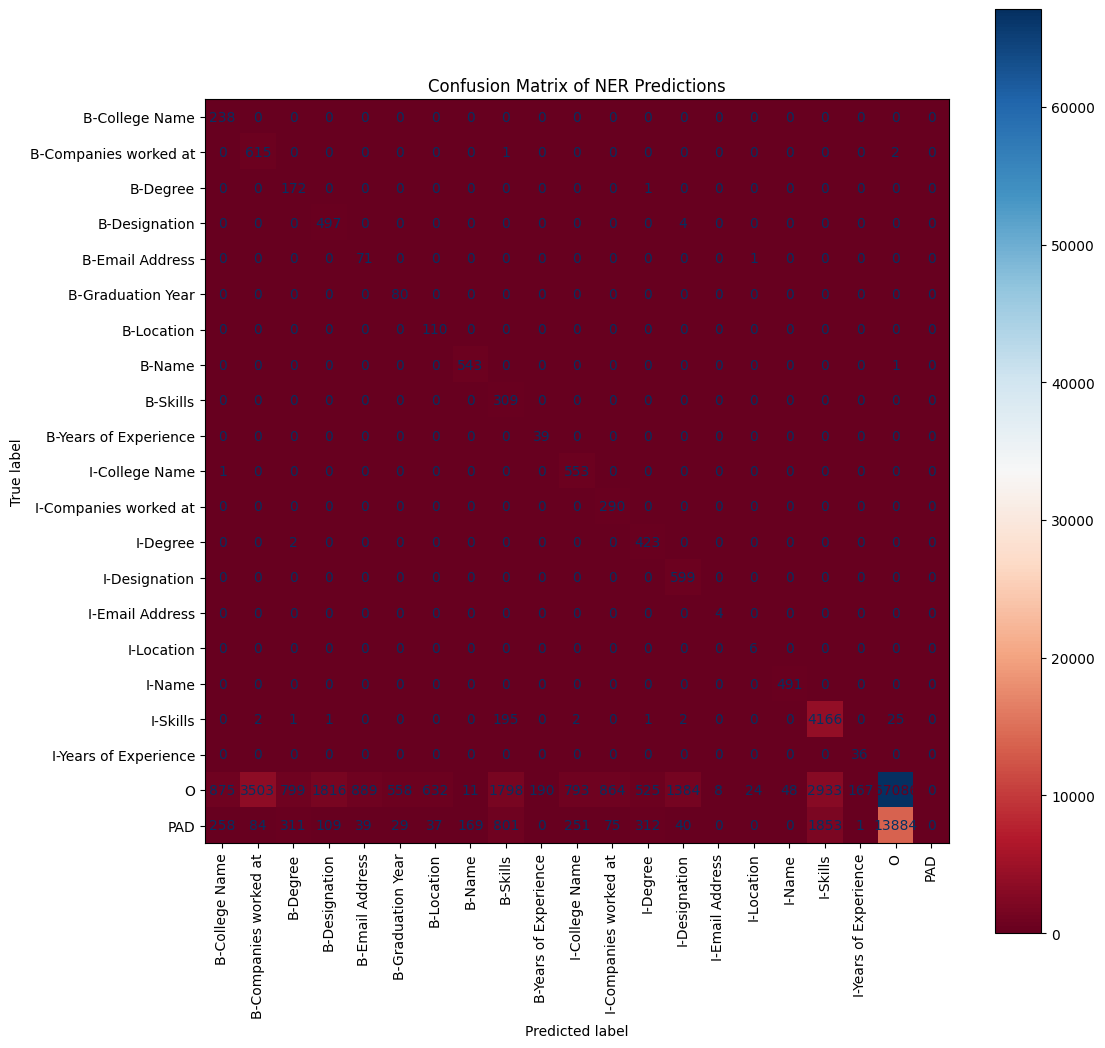

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

flat_true = [label for seq in filtered_true for label in seq]
flat_pred = [label for seq in filtered_pred for label in seq]

labels = sorted(set(flat_true + flat_pred))
cm = confusion_matrix(flat_true, flat_pred, labels=labels)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical', cmap="RdBu", ax=ax)
plt.title("Confusion Matrix of NER Predictions")
plt.show()

### Congratulations!

#### Here's what you should remember

- Named-entity recognition (NER) detects and classifies named-entities, and can help process resumes, customer reviews, browsing histories, etc. 
- You must preprocess text data with the corresponding tokenizer to the pretrained model before feeding your input into your Transformer model.